Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86 (344.00 B)

 Trainable params: 86 (344.00 B)

 Non-trainable params: 0 (0.00 B)

Episode: 1/10, Score: 15.0, Epsilon: 0.90
Episode: 2/10, Score: 10.0, Epsilon: 0.81
Episode: 3/10, Score: 20.0, Epsilon: 0.73
Episode: 4/10, Score: 25.0, Epsilon: 0.66
Episode: 5/10, Score: 14.0, Epsilon: 0.59
Episode: 6/10, Score: 9.0, Epsilon: 0.53
Episode: 7/10, Score: 12.0, Epsilon: 0.48
Episode: 8/10, Score: 8.0, Epsilon: 0.43
Episode: 9/10, Score: 12.0, Epsilon: 0.39
Episode: 10/10, Score: 13.0, Epsilon: 0.35


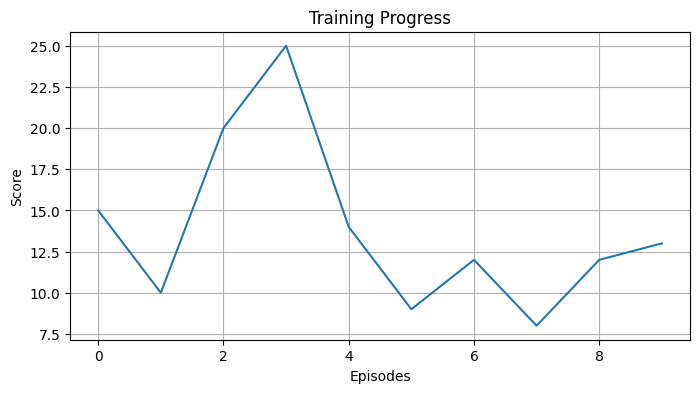


Testing trained model...
Test score: 10.0


In [20]:
# Simplified TensorFlow with Gym for Google Colab - Faster Version
# May 2025

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Install required packages (uncomment if needed)
# !pip install gymnasium

# Create environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]  # 4 values: position, velocity, angle, angular velocity
action_size = env.action_space.n             # 2 actions: move left or right

# Build a smaller model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, input_dim=state_size, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

# Training parameters - REDUCED FOR SPEED
epsilon = 1.0         # Exploration rate
epsilon_decay = 0.9   # Faster decay
epsilon_min = 0.1
gamma = 0.95          # Discount factor
memory = []
batch_size = 16       # Smaller batch
episodes = 10         # Fewer episodes

# Track scores for plotting
scores = []

# Training loop
for episode in range(episodes):
    # Reset environment
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    score = 0

    # Limit steps per episode for speed
    max_steps = 200
    for step in range(max_steps):
        # Choose action: explore or exploit
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action_values = model.predict(state, verbose=0)
            action = np.argmax(action_values[0])  # Exploit

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, state_size])
        score += reward

        # Store experience
        memory.append((state, action, reward, next_state, done))
        state = next_state

        # Train model - only train every 4 steps for speed
        if len(memory) > batch_size and step % 4 == 0:
            # Sample random batch from memory
            batch = np.random.choice(len(memory), batch_size, replace=False)
            for i in batch:
                s, a, r, next_s, d = memory[i]
                # Q-learning formula
                target = r
                if not d:
                    target = r + gamma * np.amax(model.predict(next_s, verbose=0)[0])

                target_f = model.predict(s, verbose=0)
                target_f[0][a] = target

                # Train network with a single sample
                model.fit(s, target_f, epochs=1, verbose=0)

        if done:
            break

    # Reduce exploration faster
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    scores.append(score)
    print(f"Episode: {episode+1}/{episodes}, Score: {score}, Epsilon: {epsilon:.2f}")

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Quick test of trained model
print("\nTesting trained model...")
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
score = 0
for _ in range(200):  # Limit test steps
    action_values = model.predict(state, verbose=0)
    action = np.argmax(action_values[0])
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = np.reshape(next_state, [1, state_size])
    score += reward
    if done:
        break

print(f"Test score: {score}")
env.close()

This Python code implements a basic **Deep Q-Learning agent** using TensorFlow and Gymnasium (formerly OpenAI Gym) to learn how to play the **CartPole-v1** game. Let's go through it **line by line** with explanation of **why and how it works**:

---

### 📦 Imports and Setup

```python
import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
```

* `tensorflow`: For building and training the neural network.
* `gymnasium`: Used to simulate the CartPole environment.
* `numpy`: For numerical operations, e.g., random sampling, reshaping.
* `matplotlib.pyplot`: For plotting training progress.

---

### 🌍 Create the Environment

```python
env = gym.make('CartPole-v1')
```

* Initializes the CartPole environment. The goal is to balance a pole on a cart by moving left or right.

```python
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
```

* `state_size = 4`: The environment returns a state vector of 4 values — cart position, cart velocity, pole angle, and pole angular velocity.
* `action_size = 2`: Two actions available — move left (0) or right (1).

---

### 🧠 Build the Neural Network Model

```python
model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, input_dim=state_size, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])
```

* `Dense(12, activation='relu')`: First hidden layer with 12 neurons, using ReLU to learn non-linear patterns.
* `Dense(action_size, activation='linear')`: Output layer with 2 neurons (for each action), outputs Q-values directly.

```python
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
```

* Loss function: **Mean Squared Error**, used to train the network to predict Q-values.
* Optimizer: **Adam**, good for noisy gradients and adaptive learning.

---

### 🎯 Initialize Training Parameters

```python
epsilon = 1.0
epsilon_decay = 0.9
epsilon_min = 0.1
gamma = 0.95
memory = []
batch_size = 16
episodes = 10
```

* `epsilon`: Exploration rate (initially 100% random).
* `epsilon_decay`: Controls how fast epsilon decreases.
* `epsilon_min`: Minimum exploration rate.
* `gamma`: Discount factor for future rewards (0.95 means 95% future importance).
* `memory`: Replay buffer storing past experiences `(state, action, reward, next_state, done)`.
* `batch_size`: Mini-batch size for training.
* `episodes`: Number of episodes for training (reduced for speed).

```python
scores = []
```

* To keep track of score in each episode for plotting later.

---

### 🔁 Training Loop

```python
for episode in range(episodes):
```

* Run the agent for a number of episodes.

```python
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
score = 0
max_steps = 200
```

* Reset the environment for each episode.
* Reshape the state into 2D array for model input.
* Initialize `done` and `score`.

---

### 🎮 Step Through the Environment

```python
for step in range(max_steps):
```

#### 🧠 Choose Action (ε-greedy)

```python
if np.random.rand() <= epsilon:
    action = env.action_space.sample()
else:
    action_values = model.predict(state, verbose=0)
    action = np.argmax(action_values[0])
```

* With probability `epsilon`, choose a **random action** (exploration).
* Otherwise, choose **action with highest Q-value** (exploitation).

---

#### 🚀 Apply Action and Store Experience

```python
next_state, reward, terminated, truncated, _ = env.step(action)
done = terminated or truncated
next_state = np.reshape(next_state, [1, state_size])
score += reward
memory.append((state, action, reward, next_state, done))
state = next_state
```

* Apply action and observe the new state, reward, and `done` signal.
* Reshape the next state.
* Store the experience tuple in the replay buffer.

---

#### 🧠 Train the Model

```python
if len(memory) > batch_size and step % 4 == 0:
```

* Only train if we have enough samples and every 4 steps (to reduce computation).

```python
batch = np.random.choice(len(memory), batch_size, replace=False)
for i in batch:
    s, a, r, next_s, d = memory[i]
```

* Randomly sample a batch of past experiences.

```python
    target = r
    if not d:
        target = r + gamma * np.amax(model.predict(next_s, verbose=0)[0])
```

* Q-learning update:

  * If the episode is not done:
    `target = reward + gamma * max(Q(next_state))`

```python
    target_f = model.predict(s, verbose=0)
    target_f[0][a] = target
    model.fit(s, target_f, epochs=1, verbose=0)
```

* Predict current Q-values `target_f`
* Update only the Q-value for the taken action to the `target`
* Train on this updated Q-value

---

#### 📉 Decrease Exploration

```python
epsilon = max(epsilon_min, epsilon * epsilon_decay)
```

* Decrease epsilon each episode — less exploration over time.

```python
scores.append(score)
print(f"Episode: {episode+1}/{episodes}, Score: {score}, Epsilon: {epsilon:.2f}")
```

* Store and display score and exploration rate.

---

### 📊 Plot Training Progress

```python
plt.figure(figsize=(8, 4))
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.grid(True)
plt.show()
```

* Visualize how well the model is learning over time.

---

### 🧪 Test Trained Model

```python
print("\nTesting trained model...")
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
score = 0
for _ in range(200):
    action_values = model.predict(state, verbose=0)
    action = np.argmax(action_values[0])
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = np.reshape(next_state, [1, state_size])
    score += reward
    if done:
        break
print(f"Test score: {score}")
env.close()
```

* Run the trained model in deterministic mode (no exploration).
* Predict actions using the model and measure final performance.

---

### 📄 Model Summary

The model has:

* One hidden layer with 12 neurons.
* Output layer with 2 neurons (actions).
* Only 86 trainable parameters.

---

Would you like a diagram or flowchart explaining the training loop or memory replay concept?
